# Lab 10

Hüseyin Anil Gündüz

## Imports

In [1]:
import string
from collections import Counter
from math import ceil
from typing import List, Optional, Tuple, Dict

import matplotlib.pyplot as plt
import torch
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from torchtext.datasets import IMDB
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

set_matplotlib_formats('png', 'pdf')

## Exercise 1

In this exercise, we are going to revise the sentiment classifier for IMDB reviews we
developed in a previous lab. Earlier, we encoded each review as a single "bag-of-words"
vector which had one element for each word in our dictionary set to one if that word was
found in the review, zero otherwise. This allowed us to use a simple fully-connected
neural network but, on the flip side, we lost all information contained in the ordering
and of the words and possible multiple repetitions. Recurrent neural networks, however,
are able to process reviews directly. Let's see how!

The first step is to load the data and preprocess it like it in exercise 6, so if you
still remember what we did there, feel free to skip this part.
For brevity, we only use the 10000 most common words
and truncate reviews to 250 words, but if you can use a GPU then feel free to
use the full length reviews and all words!

In [2]:
train_iterator, test_iterator = IMDB();

In [3]:
# Feed iterator to list
train_x = []
train_y = []
test_x = []
test_y = []

for label, line in train_iterator:
    train_x.append(line)
    train_y.append(label)

for label, line in test_iterator:
    test_x.append(line)
    test_y.append(label)


In [4]:
# Tokenize sentences.

def tokenize(data_list: List[str]) -> List[List[str]]:
    """
    Tokenize a list of strings.

    :param data_list: A list of strings.
    :return: A list where each entry is a list including the tokenized elements.
    """
    token_list: List[List[str]] = []
    for data_string in data_list:
        # Remove punctuation.
        data_string = data_string.translate(str.maketrans('', '', string.punctuation))
        # Split by space.
        token_list.append(data_string.split())
    return token_list


train_x = tokenize(train_x)
test_x = tokenize(test_x)


In [5]:
# Count-vectorize sentences.
class CountVectorizer:
    def __init__(self):
        self.vec_to_str_map: Dict[int, str] = {}
        self.str_to_vec_map: Dict[str, int] = {}

    def fit(self, token_list: List[str]) -> None:
        # The `Counter` object from the `collections` library gives us efficient counting
        # in large lists out of box.
        cnt = Counter(token_list)
        sorted_cnt = sorted(cnt.items(), key=lambda item: item[1], reverse=True)
        sorted_words = [key for key, val in sorted_cnt]

        # Python does not know a bidirectional mapping by default.
        # We trick a bit by simply creating two dicts, but note that this is inefficient.
        self.str_to_vec_map = {sorted_words[i]: i + 1 for i in range(len(sorted_words))}
        self.vec_to_str_map = {i + 1: sorted_words[i] for i in range(len(sorted_words))}

    def transform_to_vec(self, token_list: List[str]) -> List[int]:
        return [self.str_to_vec_map.get(word) for word in token_list]

    def transform_to_str(self, token_list: List[int]) -> List[str]:
        return [self.vec_to_str_map.get(rank) for rank in token_list]


train_words = [word for word_list in train_x for word in word_list]
test_words = [word for word_list in test_x for word in word_list]

count_vectorizer = CountVectorizer()
counter = count_vectorizer.fit(train_words)

train_x = [count_vectorizer.transform_to_vec(word_list) for word_list in train_x]
test_x = [count_vectorizer.transform_to_vec(word_list) for word_list in test_x]

In [6]:
# Discard words that are not in the top 10000
# Truncate sequences to a length of 250
# Remove Nones

def filter_word_ranks(
        word_list: List[Optional[int]],
        max_rank: int = 10000,
        max_seq_len: int = 250
) -> List[int]:
    output = []
    seq_len = 0
    for word_rank in word_list:
        if seq_len >= max_seq_len:
            return output
        elif word_rank is None:
            continue
        elif word_rank <= max_rank:
            output.append(word_rank)
            seq_len += 1
    return output


train_x = [filter_word_ranks(word_list) for word_list in train_x]
test_x = [filter_word_ranks(word_list) for word_list in test_x]

In [7]:
# Encode labels to binary targets
train_y = [1 if label == 'pos' else 0 for label in train_y]
test_y = [1 if label == 'pos' else 0 for label in test_y]

Now, each review is a vector of numbers, each corresponding to a different word:

In [8]:
print(train_x[0])

[8, 1595, 8, 35, 70, 434, 1191, 80, 4, 32, 1, 7739, 9, 3423, 10, 55, 10, 13, 89, 654, 7, 7978, 8, 91, 559, 9, 30, 89, 10, 13, 31, 835, 60, 10, 129, 787, 5, 3578, 11, 783, 2044, 110, 2, 341, 4, 94, 1165, 3150, 8, 59, 61, 5, 66, 11, 17, 12, 14, 114, 6, 6504, 187, 2, 199, 4239, 500, 1612, 777, 5011, 34, 481, 5, 847, 330, 72, 67, 41, 128, 121, 826, 72, 481, 5, 1139, 39, 5, 255, 47, 439, 4, 701, 21, 51, 1, 895, 196, 41, 809, 1008, 1328, 141, 15, 1, 2757, 969, 3, 1672, 1328, 7, 1, 2535, 2532, 121, 194, 2193, 7740, 3, 1999, 4, 41, 64, 5012, 21, 2549, 72, 43, 423, 16, 39, 500, 1774, 8513, 3, 1052, 12, 216, 1116, 71, 41, 8, 6, 9, 1831, 154, 614, 11, 13, 1165, 8972, 2069, 1, 423, 3, 1048, 139, 22, 164, 3, 243, 194, 65, 107, 37, 24, 333, 36, 47, 6972, 88, 5058, 441, 70, 357, 162, 10, 1635, 7, 677, 423, 3, 1048, 22, 2, 723, 7, 4239, 496, 380, 5218, 5059, 64, 1564, 5, 48, 175, 522, 305, 2092, 61, 423, 139, 7, 23, 3817, 12, 8, 84, 1, 902, 17, 1, 189, 9, 100, 423, 613, 7, 1, 19, 6, 613, 17, 1618, 555

Even though RNNs can process sequences of arbitrary length, all sequences in the same
batch must be of the same length, while sequences in different batches can have different
length. In this case, however, we pad all sequences to the same length as this makes for
much simpler code.
PyTorch provides a function to do so for you called `pad_sequence` (read the documentation!).
Hint: It might be good to set the argument `batch_first` to `True.
Beforehand, we need to convert the data to tensors. Let's also define our device and push
the newly created padded tensor to it.

In [9]:
device = (
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

train_x = [torch.tensor(word_list, dtype=torch.int) for word_list in train_x]
test_x = [torch.tensor(word_list, dtype=torch.int) for word_list in test_x]

train_x = (
    pad_sequence(train_x, batch_first=True).to(device)
)

test_x = (
    pad_sequence(test_x, batch_first=True).to(device)
)

train_y = torch.tensor(train_y, dtype=torch.float, device=device)
test_y = torch.tensor(test_y, dtype=torch.float, device=device)

In [10]:
print(train_x.shape)

torch.Size([25000, 250])


The data is now an array of shape `(num_samples x seq_len)`.
A PyTorch RNN with `batch_first=True` option expects the input to be of shape
`(num_samples x seq_len x features)`. Although we have a univariate timeseries, we still
need to add this additional last dimension.

In [11]:
train_x = (
    train_x.unsqueeze(-1)
)

test_x = (
    test_x.unsqueeze(-1)
)

Finally let's create our `IMDBDataset` object:

In [12]:

class IMDBDataset(Dataset):
    def __init__(self, data: Tensor, labels: Tensor):
        self.data = data
        self.labels = labels

    @property
    def shape(self) -> Tuple:
        return self.data.shape

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return self.data[idx], self.labels[idx]

Next, we define our sequential model. The first layer is an _Embedding_ layer that
associates a vector of numbers to each word in the vocabulary. These numbers are updated
during training just like all other weights in the network. Crucially, thanks to this
embedding layer we do not have to one-hot-encode the reviews but we can use the word
indices directly, making the process much more efficient.

Note the parameter `padding_idx`: this indicates that zeros in the input sequences are
used for padding (verify that this is the case!). Internally, this is used by the RNN to
ignore padding tokens, preventing them from contributing to the gradients (read more in
the user guide, [link](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html/)!)

We also make use of a `nn.Module` container, where we will define our model. This
gives us more flexibility in the flow of the network. Here we add the model blocks
as class attributes and define a forward pass, which is enough for the autograd engine.

The shapes and dimensions of tensors can now be a bit tricky. It helps if you print
the resulting shape of each transformation to console and investigate what happened!

In [13]:
class LSTMModel(nn.Module):
    def __init__(self):
        # A class that inherits from nn.Module needs to call the constructor from the
        # parent class
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=10001,
            embedding_dim=64,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=32,
            num_layers=2,
            batch_first=True
        )

        self.fc = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: Tensor) -> Tensor:
        # The output needs to be reshaped or otherwise we have a dimension too much.
        x = self.embedding(x).squeeze(2)

        # The LSTM module gives a variety of outputs. Please refer to the official
        # docs for a detailed description. Here `hidden` contains the final hidden states
        # from the last layer for every sample in the batch.
        _, (hidden, _) = self.lstm(x)

        # We need to extract the last hidden state
        y_score = self.fc(hidden[-1])
        y_hat = self.sigmoid(y_score).squeeze(-1)

        return y_hat

In the next step, we once again need our beloved training loop.

In [14]:

def train(
        model: nn.Module,
        loss: nn.Module,
        optimizer: Optimizer,
        train_dataset: Dataset,
        test_dataset: Dataset,
        epochs: int,
        batch_size: int
) -> Dict:
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    num_train_batches = ceil(len(train_dataset) / batch_size)
    num_test_batches = ceil(len(test_dataset) / batch_size)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        ################################################################################
        # TRAINING LOOP
        ################################################################################

        for batch_idx, (x, y) in enumerate(train_loader):

            y_hat = model(x)
            batch_loss = loss(y_hat, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)),
                      end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.where(y_hat > 0.5, 1, 0) == y))

        ep_train_loss = total_loss / len(train_dataset)
        ep_train_acc = num_correct / len(train_dataset)

        total_loss = 0
        num_correct = 0

        ################################################################################
        # TEST LOOP
        ################################################################################

        for batch_idx, (x, y) in enumerate(test_loader):

            with torch.no_grad():
                y_hat = model(x)
                batch_loss = loss(y_hat, y)

            if batch_idx % 50 == 0:
                print('TEST BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_test_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)
            num_correct += int(torch.sum(torch.where(y_hat > 0.5, 1, 0) == y))

        ep_test_loss = total_loss / len(test_dataset)
        ep_test_acc = num_correct / len(test_dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['test_loss'].append(ep_test_loss)
        metrics['test_acc'].append(ep_test_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tTEST LOSS:\t'
              '{:.3f}\tTEST ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_test_loss, ep_test_acc))
    return metrics

We declare model, optimizer, datasets, loss, epochs, batch size and then start training!

In [15]:
epochs = 10
batch_size = 32

model = (
    LSTMModel().to(device)
)

optimizer = (
    Adam(model.parameters(), lr=5e-3)
)

loss = (
    nn.BCELoss()
)

train_dataset = (
    IMDBDataset(train_x, train_y)
)

test_dataset = (
    IMDBDataset(test_x, test_y)
)

metrics = train(model, loss, optimizer, train_dataset, test_dataset, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	0.022	TRAIN ACCURACY:	0.506	TEST LOSS:	0.022	TEST ACCURACY:	0.500
EPOCH:	    2	TRAIN LOSS:	0.022	TRAIN ACCURACY:	0.512	TEST LOSS:	0.022	TEST ACCURACY:	0.521
EPOCH:	    3	TRAIN LOSS:	0.021	TRAIN ACCURACY:	0.547	TEST LOSS:	0.022	TEST ACCURACY:	0.517
EPOCH:	    4	TRAIN LOSS:	0.017	TRAIN ACCURACY:	0.713	TEST LOSS:	0.013	TEST ACCURACY:	0.825
EPOCH:	    5	TRAIN LOSS:	0.009	TRAIN ACCURACY:	0.886	TEST LOSS:	0.012	TEST ACCURACY:	0.840
EPOCH:	    6	TRAIN LOSS:	0.005	TRAIN ACCURACY:	0.940	TEST LOSS:	0.012	TEST ACCURACY:	0.853
EPOCH:	    7	TRAIN LOSS:	0.003	TRAIN ACCURACY:	0.966	TEST LOSS:	0.014	TEST ACCURACY:	0.847
EPOCH:	    8	TRAIN LOSS:	0.003	TRAIN ACCURACY:	0.975	TEST LOSS:	0.015	TEST ACCURACY:	0.845
EPOCH:	    9	TRAIN LOSS:	0.002	TRAIN ACCURACY:	0.981	TEST LOSS:	0.018	TEST ACCURACY:	0.844
EPOCH:	   10	TRAIN LOSS:	0.001	TRAIN ACCURACY:	0.988	TEST LOSS:	0.019	TEST ACCURACY:	0.842


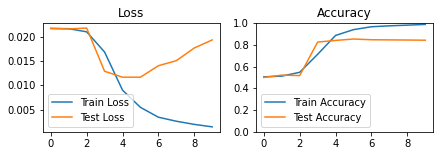

In [16]:

def get_training_progress_plot(
        train_losses: List[float],
        train_accs: List[float],
        val_losses: List[float],
        val_accs: List[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Test Loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Test Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend()


get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['test_loss'],
    metrics['test_acc'],
)

The model seems to be learning more easily than the simple baseline we created time ago,
which had an accuracy of 85-88% on the test data.
Let it train for longer and tune the
architecture above to reach as high accuracy as possible! (note that evaluating on the
same data that you used for early stopping is cheating).


## Exercise 2

In this exercise, we are going to build a model that is able to sum two numbers, each given as a sequence
of images of handwritten digits. The network will first use a convolutional encoder to transform each
digit into a feature vector. These feature vectors will then be processed by a LSTM that will produce as
output each digit of the sum.

### Dataset
We are now going to create a synthetic dataset using images from MNIST.

First, we define some auxiliary functions.
We need a function that converts an integer to a padded tensor.

In [17]:

def convert_int_to_vector(num: int, length: int) -> Tensor:
    """
    Take an integer and convert it to a vector.

    Example: 123 with a length of 3 returns a tensor with [1, 2, 3].
    5 with a length of 3 returns [0, 0, 5]
    """
    num_str = str(num).zfill(length)
    return torch.tensor([int(n) for n in num_str])

Then, we need a function that generates our training labels.
The result of the function should be a dictionary that contains 3 tensors (first numbers, second numbers, sum of first + second) of shape `(num_samples, max_length)`.
We need the summands for drawing matching images later, while the latter is our actual label.

In [18]:

def generate_labels(num_samples: int, max_length: int) -> Dict:
    """
    Generate random numbers, whose sum does not exceed maximum length.

    We will pad numbers that are less than max_length with zeros.
    """

    num_1s = []
    num_2s = []
    sums = []

    for _ in range(num_samples):

        # Ensure the sum always has at most max_len digits
        num_1 = torch.randint(10**max_length // 2 - 1, (1,))
        num_2 = torch.randint(10**max_length // 2 - 1, (1,))

        num_1s.append(convert_int_to_vector(int(num_1), max_length))
        num_2s.append(convert_int_to_vector(int(num_2), max_length))

        sums.append(convert_int_to_vector(int(num_1 + num_2), max_length))

    return {
        'num_1': torch.stack(num_1s),
        'num_2': torch.stack(num_2s),
        'sum': torch.stack(sums)
    }

For our training, we need our `Dataset` object. Here, we will also draw the images to create our input tensors. One image is of shape `(1 x 28 x 28)`.
Thus, a constructed input tensor is of shape `(max_length x 1 x 28 x 28)`

In [19]:

class NumberMNIST(Dataset):
    def __init__(
            self,
            max_length: int = 3,
            train: bool = True
    ) -> None:
        mnist_base = MNIST('.data', train=train, download=True)
        mnist_base.data = mnist_base.data.float() / 255

        self.max_length = max_length
        # We choose 20k samples for training and 5k for testing.
        self.num_samples = 20000 if train else 5000
        self.digit_idxs = NumberMNIST._generate_digit_groups(mnist_base.targets)

        self.labels = generate_labels(self.num_samples, self.max_length)

        self.num_1s = torch.zeros(self.num_samples, self.max_length, 1, 28, 28)
        self.num_2s = torch.zeros(self.num_samples, self.max_length, 1, 28, 28)

        for i in range(self.num_samples):

            imgs = []
            for num_1_digit in self.labels['num_1'][i]:
                # Get corresponding index group
                digit_idxs = self.digit_idxs[int(num_1_digit)]
                # Sample a random index from the digit class
                rand_idx = digit_idxs[torch.randint(len(digit_idxs), (1, ))]
                # Obtain image for the sampled index
                imgs.append(mnist_base.data[rand_idx])
            # Add images to main tensor.
            self.num_1s[i] = torch.stack(imgs)

            imgs = []
            for num_2_digit in self.labels['num_2'][i]:
                digit_idxs = self.digit_idxs[int(num_2_digit)]
                rand_idx = digit_idxs[torch.randint(len(digit_idxs), (1, ))]
                imgs.append(mnist_base.data[rand_idx])
            self.num_2s[i] = torch.stack(imgs)



    @staticmethod
    def _generate_digit_groups(targets: Tensor) -> Dict:
        """Separates the dataset in groups based on the label. Returns a Dict with indices."""
        res = {}
        for i in range(10):
            idxs = (targets == i).nonzero().squeeze(-1)
            res.update({i: idxs})
        return res

    @property
    def shape(self) -> Tuple:
        return self.data.shape

    def __len__(self) -> int:
        return len(self.num_1s)

    def __getitem__(self, idx: int) -> Dict:
        return {
            'num_1': self.num_1s[idx],
            'num_2': self.num_2s[idx],
            'label': self.labels['sum'][idx],
        }

Let's initialize our datasets and see if everything works as expected.

In [20]:
train_dataset = NumberMNIST(train=True, max_length=3)
test_dataset = NumberMNIST(train=False, max_length=3)

Sum: [7, 9, 3]


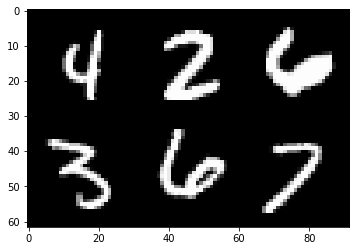

In [21]:
def plot_digits(num_1: Tensor, num_2: Tensor) -> None:
    grid_img = make_grid(torch.cat([num_1, num_2]), nrow=3)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

idx = int(torch.randint(len(test_dataset), (1,)))
sample = test_dataset[idx]

print('Sum:', [int(i) for i in sample['label']])
plot_digits(sample['num_1'], sample['num_2'])

### The model

Let's now see how to create the model.

This network will have two inputs, one for each number. The numbers have three digits, each of which is an image of size 1 x 28 x 28.

In [22]:
class AdditionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 128

        # The network will use the same convolutional encoder for all digits in both numbers.
        # Let us first define this encoder as its own submodule, a normal CNN:

        self.digit_encoder = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, self.latent_dim, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Our second model in this szenario will be a bidrectional LSTM.
        # The input for this model are the concatenated latent vectors that we obtained from
        # the digit encoder.
        # For flexibility, we do not use a sequential but have the final layers as single attributes in this module class.

        # Let's also apply a bit of dropout to prevent overfitting too much.
        self.dropout = (
            nn.Dropout(0.3)
        )

        self.lstm = (
            nn.LSTM(
                input_size=self.latent_dim * 2,
                hidden_size=64,
                batch_first=True,
                bidirectional=True
            )
        )

        # Finally, we add a fully connected layer as output.
        # Note that the input size of the linear layer should be twice the hidden size
        # of the LSTM (bidirectional).
        self.fc = (
            nn.Linear(128, 10)
        )


    def forward(self, num_1: Tensor, num_2: Tensor) -> Tensor:
        # Note: num_1 and num_2 are of shape (batch_size x max_length x 1 x 28 x 28)
        batch_size = num_1.shape[0]
        max_length = num_1.shape[1]

        enc_1 = torch.zeros(batch_size, max_length, self.latent_dim, device=num_1.device)
        enc_2 = torch.zeros(batch_size, max_length, self.latent_dim, device=num_1.device)
        for i in range(max_length):
            enc_1[:, i] = self.digit_encoder(num_1[:, i]).view(batch_size, -1)
            enc_2[:, i] = self.digit_encoder(num_2[:, i]).view(batch_size, -1)

        # After we apply the CNN to both numbers, we need to "merge" the two sequence of vectors.
        # There are several options here, here we choose to concatenate the two tensor in each time-step
        # to produce a single tensor of shape (batch_size, max_len, latent_dim * 2).
        enc_total = (
            torch.cat([enc_1, enc_2], dim=2)
        )

        # Now, we pass the total encoded tensor through the dropout, lstm and output layer.
        enc_total = self.dropout(enc_total)

        # We obtain all hidden states from each timestep resulting in a tensor of shape (batch_size, max_length, lstm_hidden_dim)
        out, _ = self.lstm(enc_total)
        # Due to broadcasting, we can feed this tensor directly to the fully connected layer.
        out = self.fc(out)
        # Our loss function does accept a tensor of shape (batch_size, num_classes, max_length)
        # So we reshape before returning the network output.
        return out.permute(0, 2, 1)

We can mainly reuse the training loop from the exercise before, but we need to change the computation of the accuracy and dataloading.
Let's initialize our modules and start training!

In [23]:
device = (
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

def train(
        model: AdditionModel,
        loss: nn.Module,
        optimizer: Optimizer,
        train_dataset: Dataset,
        test_dataset: Dataset,
        epochs: int,
        batch_size: int
) -> Dict:
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
    }

    num_train_batches = ceil(len(train_dataset) / batch_size)
    num_test_batches = ceil(len(test_dataset) / batch_size)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size)

    for ep in range(1, epochs + 1):
        total_loss = 0
        num_correct = 0

        ################################################################################
        # TRAINING LOOP
        ################################################################################

        for batch_idx, sample in enumerate(train_loader):

            num_1 = sample['num_1'].to(device)
            num_2 = sample['num_2'].to(device)
            y = sample['label'].to(device)


            y_hat = model(num_1, num_2)
            batch_loss = loss(y_hat, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_train_batches, float(batch_loss)),
                      end='\r')

            total_loss += float(batch_loss)

            num_correct += int(torch.sum(torch.all(torch.eq(torch.argmax(y_hat, dim=1), y), dim=1)))

        ep_train_loss = total_loss / len(train_dataset)
        ep_train_acc = num_correct / len(train_dataset)

        total_loss = 0
        num_correct = 0

        ################################################################################
        # TEST LOOP
        ################################################################################

        for batch_idx, sample in enumerate(test_loader):
            num_1 = sample['num_1'].to(device)
            num_2 = sample['num_2'].to(device)
            y = sample['label'].to(device)

            with torch.no_grad():
                y_hat = model(num_1, num_2)
                batch_loss = loss(y_hat, y)

            if batch_idx % 50 == 0:
                print('TEST BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                      .format(batch_idx, num_test_batches, float(batch_loss)), end='\r')

            total_loss += float(batch_loss)

            num_correct += int(torch.sum(torch.all(torch.eq(torch.argmax(y_hat, dim=1), y), dim=1)))

        ep_test_loss = total_loss / len(test_dataset)
        ep_test_acc = num_correct / len(test_dataset)

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['test_loss'].append(ep_test_loss)
        metrics['test_acc'].append(ep_test_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.3f}\tTEST LOSS:\t'
              '{:.3f}\tTEST ACCURACY:\t{:.3f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_test_loss, ep_test_acc))
    return metrics

Let's initialize our modules and start training!


In [24]:
epochs = 20
batch_size = 32

model = (
    AdditionModel().to(device)
)

optimizer = (
    Adam(model.parameters())
)

loss = (
    nn.CrossEntropyLoss()
)

metrics = train(model, loss, optimizer, train_dataset, test_dataset, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	0.060	TRAIN ACCURACY:	0.027	TEST LOSS:	0.043	TEST ACCURACY:	0.104
EPOCH:	    2	TRAIN LOSS:	0.033	TRAIN ACCURACY:	0.257	TEST LOSS:	0.024	TEST ACCURACY:	0.429
EPOCH:	    3	TRAIN LOSS:	0.019	TRAIN ACCURACY:	0.540	TEST LOSS:	0.015	TEST ACCURACY:	0.647
EPOCH:	    4	TRAIN LOSS:	0.014	TRAIN ACCURACY:	0.684	TEST LOSS:	0.012	TEST ACCURACY:	0.733
EPOCH:	    5	TRAIN LOSS:	0.011	TRAIN ACCURACY:	0.759	TEST LOSS:	0.011	TEST ACCURACY:	0.755
EPOCH:	    6	TRAIN LOSS:	0.009	TRAIN ACCURACY:	0.799	TEST LOSS:	0.009	TEST ACCURACY:	0.801
EPOCH:	    7	TRAIN LOSS:	0.007	TRAIN ACCURACY:	0.832	TEST LOSS:	0.008	TEST ACCURACY:	0.814
EPOCH:	    8	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.853	TEST LOSS:	0.008	TEST ACCURACY:	0.826
EPOCH:	    9	TRAIN LOSS:	0.006	TRAIN ACCURACY:	0.871	TEST LOSS:	0.007	TEST ACCURACY:	0.837
EPOCH:	   10	TRAIN LOSS:	0.005	TRAIN ACCURACY:	0.880	TEST LOSS:	0.007	TEST ACCURACY:	0.841
EPOCH:	   11	TRAIN LOSS:	0.005	TRAIN ACCURACY:	0.888	TEST LOSS:	0.007	TEST ACCURACY:	0.843

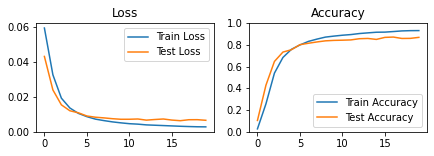

In [25]:

get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['test_loss'],
    metrics['test_acc'],
)

It is amazing what we achieved with such a small (for the standard of deep learning) model and dataset!